<a href="https://colab.research.google.com/github/BhagatSurya/NLP/blob/main/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

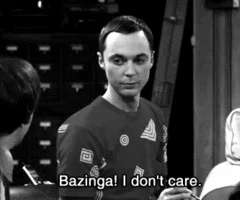

**Dataset from Kaggel** : https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

In [ ]:
#unzip the data 
import zipfile
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/Sarcasm_Headlines_Dataset.json.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/Sarcasm_Headlines_Dataset.json"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
import pandas as pd
df = pd.read_json('/content/Sarcasm_Headlines_Dataset.json',lines=True)

In [ ]:
df.head()


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


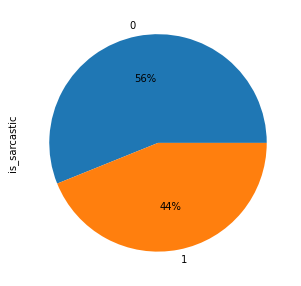

In [ ]:
df.is_sarcastic.value_counts().plot.pie(figsize=(5, 5),autopct='%1.0f%%')

1 = sarcastic

0 = Not sarcastic

#Text Preprossing 

In [ ]:
df.shape

(26709, 3)

In [ ]:
df = df.drop(['article_link'], axis=1)#Droping the article_link coloum 
df.head() 

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df.info()#geting the information of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(df)-5) # create random indexes not higher than the total number of samples
for i in df[["headline", "is_sarcastic"]][random_index:random_index+5].itertuples():
  _, headline ,is_sarcastic = i
  print(f"Target: {is_sarcastic}", "(real sarcastic)" if is_sarcastic > 0 else "(not real sarcastic)")
  print(f"Text:\n{headline}\n")
  print("---\n")

Target: 0 (not real sarcastic)
Text:
boston teachers visit students' countries of origin to bridge cultural divide

---

Target: 1 (real sarcastic)
Text:
lindsey graham asks nearby family to take his picture for photo op

---

Target: 1 (real sarcastic)
Text:
nation thankful that shellie dean zimmerman was charged with perjury at least

---

Target: 1 (real sarcastic)
Text:
woman's body confusing jumble of celtic, egyptian, japanese symbols

---

Target: 1 (real sarcastic)
Text:
detective endangers own life by looking forward to upcoming retirement

---



In [ ]:
from sklearn.model_selection import train_test_split #spliting the train and test 
train_text, test_text,train_target,test_target = train_test_split(df["headline"].to_numpy(),
                                                                            df["is_sarcastic"].to_numpy(),
                                                                            test_size=0.2, # dedicate 20% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [ ]:
train_text.shape,train_target.shape #shape of the train text and target 

((21367,), (21367,))

In [ ]:
test_text.shape,test_target.shape #shape of the test text and target 

((5342,), (5342,))

# Text vectorization [tokenization]

In [ ]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_text])/len(train_text))

10

In [ ]:
round(sum([len(i.split()) for i in test_text])/len(test_text))

10

In [ ]:
import tensorflow  as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 10 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
text_vectorizer.adapt(train_text)


In [ ]:
sample_sentence = "marcus mariota featured in inspiring beats by dre ad!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[   1,    1, 4784,    5, 2609, 3867,   20,    1,  392,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'to', 'of', 'the']
Bottom 5 least common words: ['rouge', 'rosetta', 'rosenstein', 'roseanne', 'rory']


#embedding

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

#model_MNB

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline


model_MNB= Pipeline([
    ('tfidf',TfidfVectorizer()),#convert words to numbers using tfidf
    ('MNB',MultinomialNB()) # Multinomial naive bayes
])

model_MNB.fit(train_text,train_target)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('MNB', MultinomialNB())])

In [ ]:
baseline_score = model_MNB.score(test_text, test_target)

In [ ]:
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")


Our baseline model achieves an accuracy of: 81.24%


In [ ]:
model_MNB.score(train_text, train_target)

0.9138858988159311

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_preds = model_MNB.predict(test_text)


In [ ]:
baseline_preds[:20]

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [ ]:
baseline_results = calculate_results(y_true=test_target,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 81.24298015724449,
 'precision': 0.8240939976639432,
 'recall': 0.8124298015724448,
 'f1': 0.8073208302903775}

#Dene Model 

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-08-24 17:54:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-24 17:54:15 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
#functional Aip 
#model creation
tf.random.set_seed(42)
from tensorflow.keras import layers
Inputs =  layers.Input(shape=(1,),dtype='string')
x = text_vectorizer(Inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(2,activation='relu')(x)
#x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
Dense_model = tf.keras.Model(Inputs,outputs,name='Dens_model')

In [ ]:
#model compile 
Dense_model.compile(loss="binary_crossentropy",
                    optimizer =tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

In [ ]:
#Early Stop 
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training


In [ ]:
# Creating learning rate reduction callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Fit the model
Dense_model_history = Dense_model.fit(train_text, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_target,
                              epochs=100,
                              validation_data=(test_text, test_target),
                              callbacks=[lr_scheduler])

Epoch 1/100
668/668 [==============================] - 13s 18ms/step - loss: 0.5561 - accuracy: 0.7626 - val_loss: 0.5363 - val_accuracy: 0.8167 - lr: 1.0000e-04
Epoch 2/100
668/668 [==============================] - 12s 18ms/step - loss: 0.4173 - accuracy: 0.9435 - val_loss: 0.4358 - val_accuracy: 0.8431 - lr: 1.1220e-04
Epoch 3/100
668/668 [==============================] - 11s 17ms/step - loss: 0.2906 - accuracy: 0.9606 - val_loss: 0.3746 - val_accuracy: 0.8435 - lr: 1.2589e-04
Epoch 4/100
668/668 [==============================] - 12s 18ms/step - loss: 0.2069 - accuracy: 0.9629 - val_loss: 0.3587 - val_accuracy: 0.8426 - lr: 1.4125e-04
Epoch 5/100
668/668 [==============================] - 12s 17ms/step - loss: 0.1583 - accuracy: 0.9652 - val_loss: 0.3701 - val_accuracy: 0.8424 - lr: 1.5849e-04
Epoch 6/100
668/668 [==============================] - 12s 17ms/step - loss: 0.1281 - accuracy: 0.9681 - val_loss: 0.3959 - val_accuracy: 0.8409 - lr: 1.7783e-04
Epoch 7/100
668/668 [=======

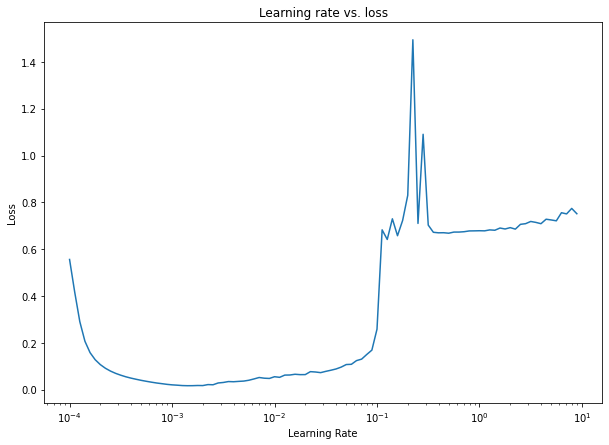

In [ ]:
# plot training history
# Plot the learning rate versus the loss
import matplotlib.pyplot as plt
import numpy as np
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, Dense_model_history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

In [ ]:
pd.DataFrame(Dense_model_history.history).plot(figsize=(10,7), xlabel="epochs");


In [ ]:
lr_df = pd.DataFrame(Dense_model_history.history)

In [ ]:
lr_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.685633,0.691487,0.674129,0.708536,0.000100
1,0.649340,0.743343,0.627819,0.733246,0.000112
2,0.589120,0.791314,0.575236,0.771995,0.000126
3,0.529475,0.837600,0.531341,0.815987,0.000141
4,0.478183,0.868723,0.496940,0.837140,0.000158
...,...,...,...,...,...
95,0.720354,0.540553,1.362455,0.580681,5.623413
96,0.747087,0.541770,1.398636,0.580681,6.309574
97,0.761014,0.532644,1.573039,0.580681,7.079458
98,0.776619,0.534750,1.319049,0.580681,7.943282


In [ ]:
lr_df['accuracy'].mean()

0.8035812246799469

In [ ]:
lr_df['val_accuracy'].median()

EXP 1